In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

## FLOW:

This study is going the examine the dataset that contains the quarterly number of international tourists to Australia for the period 1999–2015. By applying time-series analysis, with seasonal differencing and ARIMA models, I aim to simply achieve a model that outputs accurate predictions.

In [7]:
tour_df=pd.read_csv('austourists.csv').set_index('Unnamed: 0')

In [8]:
y = tour_df["x"]

### Let's plot the data to observe:

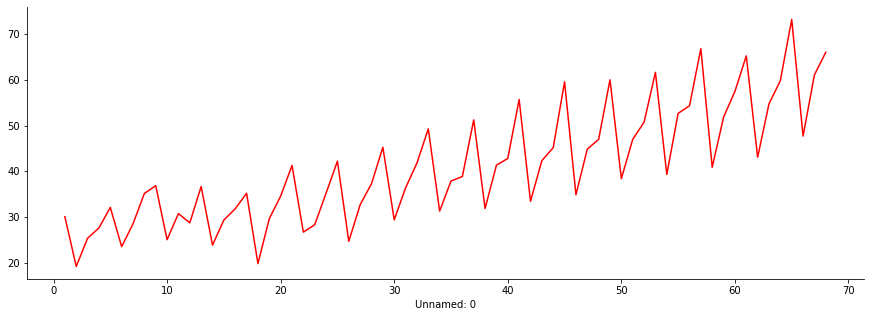

In [10]:
fig, ax= plt.subplots(figsize=(15,5))
y.plot(color="red")
sns.despine()
plt.show()

##### When the graph is examined, we see an increasing trend with seasonality. Besides, the variation also increases with time.

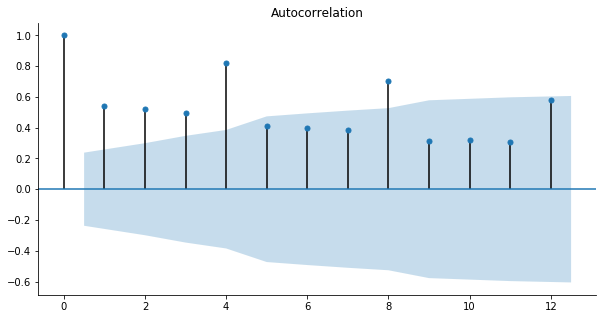

In [11]:
fig,ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_acf(y,lags=12, ax=ax)
sns.despine()
plt.show()

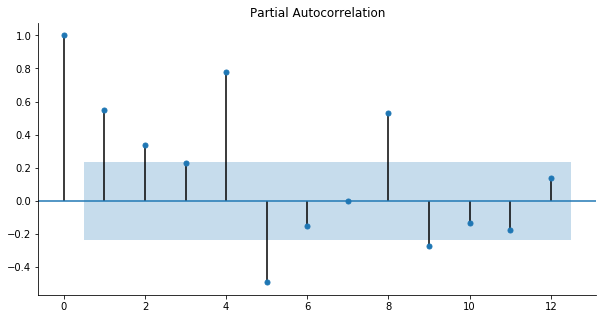

In [12]:
fig,ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_pacf(y,lags=12, ax=ax)
sns.despine()
plt.show()

##### From the ACF we see that each 4th quarter has high autocorrelation - seasonality. And from the PACF we observe that data is not stationary

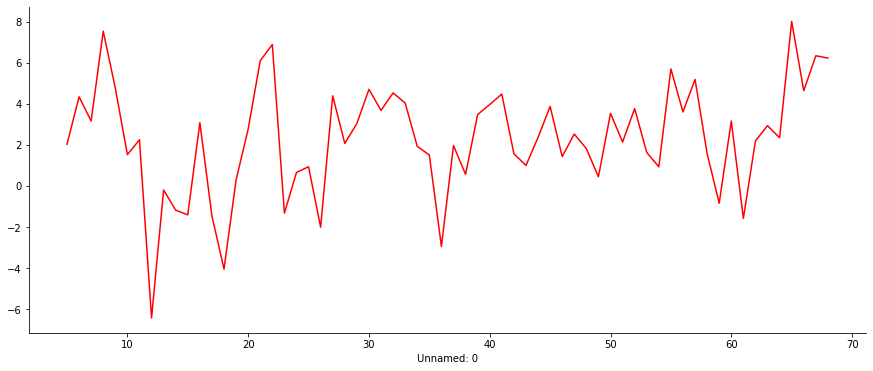

In [13]:
diff4 = (y - y.shift(4)).dropna()

fig,ax = plt.subplots(figsize=(15,6))
diff4.plot(color="red",ax=ax)
sns.despine()
plt.show()

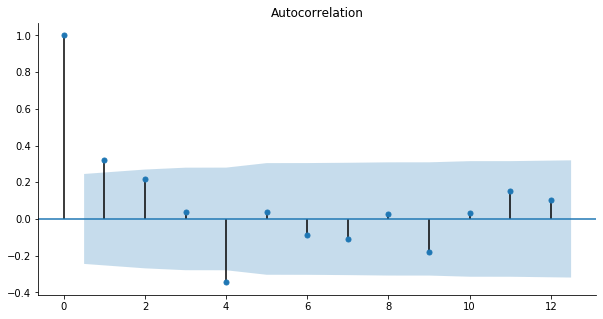

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_acf(diff4,lags=12, ax=ax)
sns.despine()
plt.show()

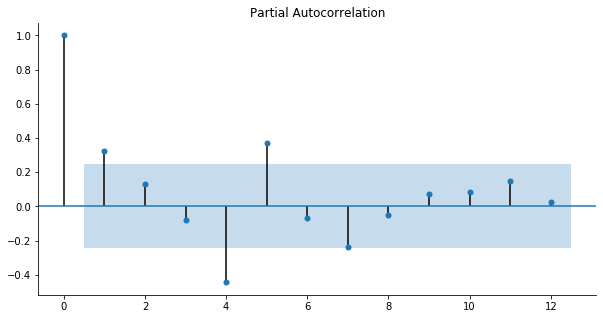

In [15]:
fig,ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_pacf(diff4,lags=12, ax=ax)
sns.despine()
plt.show()

In [16]:
sm.tsa.stattools.kpss(diff4)

C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.32406613815712315,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### I would choose ARIMA(4,1,2) model from PACF and ACF:

In [19]:
arima4 = sm.tsa.ARIMA(diff4, order=(4, 1, 2)).fit(trend='nc')
print(arima4.summary())
print("sigma squared is estimated as:",round(arima4.sigma2,3))
print("AICc is estimated as:",round(calculate_aicc(arima4),3))

C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.x   No. Observations:                   63
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -142.180
Method:                       css-mle   S.D. of innovations              2.277
Date:                Sat, 16 Jan 2021   AIC                            298.361
Time:                        19:37:30   BIC                            313.363
Sample:                             1   HQIC                           304.261
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.x     -0.3783      0.191     -1.983      0.047      -0.752      -0.004
ar.L2.D.x     -0.2210      0.235     -0.939      0.348      -0.682       0.240
ar.L3.D.x     -0.1699      0.137     -1.241      0.2

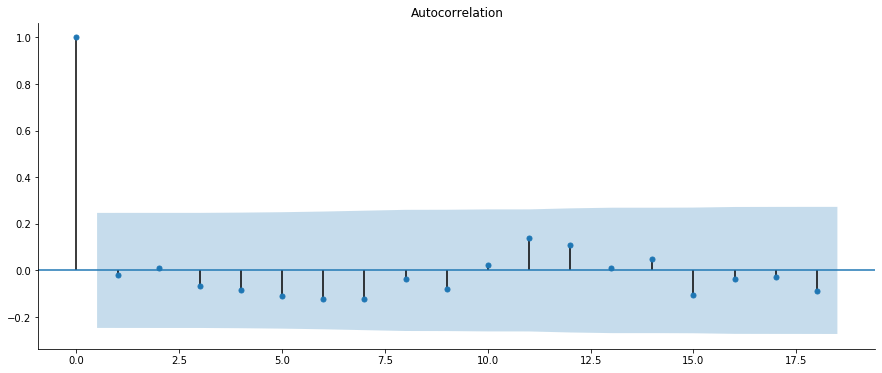

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(arima4.resid, ax=ax)
sns.despine()
plt.show()

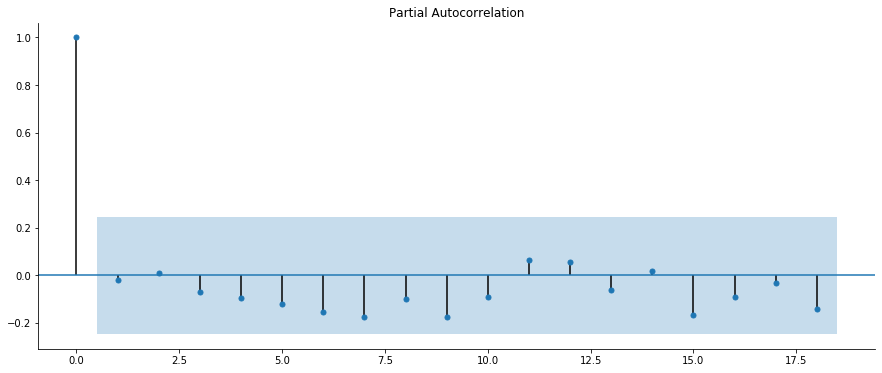

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_pacf(arima4.resid, ax=ax)
sns.despine()
plt.show()

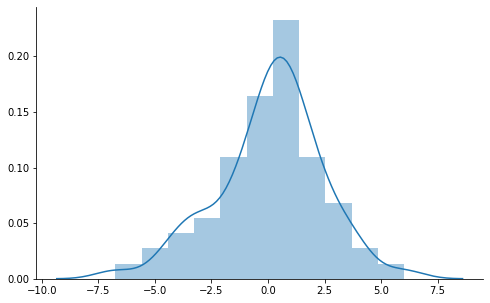

In [25]:
fig, ax= plt.subplots(figsize=(8,5))
sns.distplot(arima4.resid, ax=ax)
sns.despine()
plt.show()

In [28]:
sm.stats.acorr_ljungbox(arima4.resid,lags=[12])

(array([6.99532263]), array([0.8579225]))

##### Seems like my model selection is appropriate

In [29]:
from pmdarima.arima import auto_arima

arima5=auto_arima(y,seasonal=False)
arima5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -158.518
Date:                Sat, 16 Jan 2021   AIC                            331.037
Time:                        19:43:23   BIC                            346.470
Sample:                             0   HQIC                           337.144
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3914      0.606      3.943      0.000       1.203       3.580
ar.L1         -0.9953      0.027    -36.963      0.000      -1.048      -0.943
ar.L2         -0.9947      0.026    -38.999      0.000      -1.045      -0.945
ar.L3         -0.9868      0.021    -47.923      0.000      -1.027      -0.946
ma.L1          0.2131      0.164      1.303      0.193      -0.107       0.534
ma.L2          0.5696      0.132      4.312      0.000       0.311       0.828
sigma2         5.7362      1.039      5.521      0.000       3.700       7.772
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 5.96
Prob(Q):                              0.75   Prob(JB):                         0.05
Heteroskedasticity (H):               0.45   Skew:                            -0.68
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

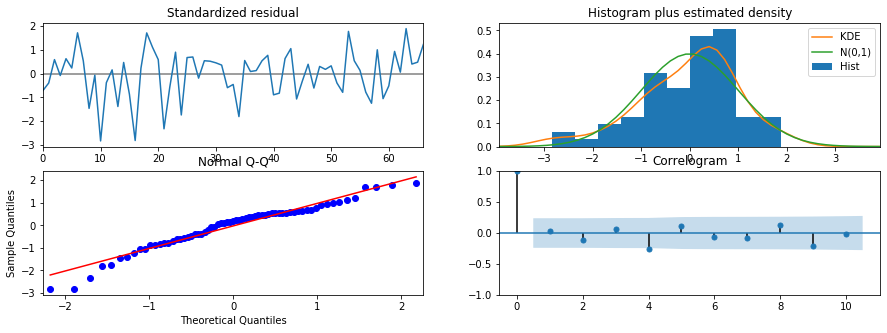

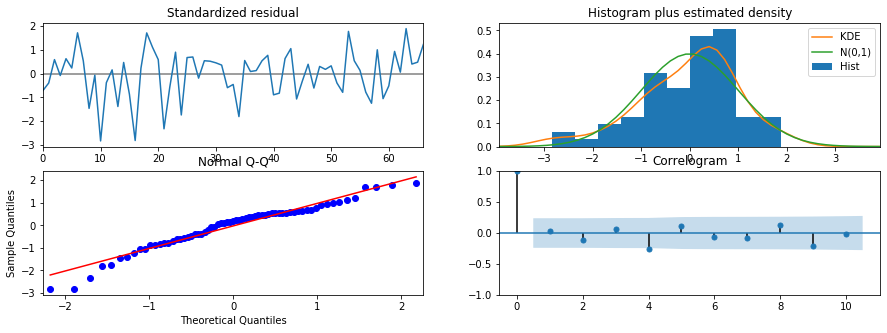

In [31]:
arima5.plot_diagnostics(figsize=(15,5))

#### Results are similar but autoarima is slightly better

Backshift: (1-ϕ1B-ϕ2B^2-ϕ3B^3)*(1-B)*(yt)=(1+θ1B+θ2B^2)*εt

W/out backshift: (1-ϕ1(yt)-ϕ2(yt-2)-ϕ3(yt-3))*(1-yt)*(yt)=(1+θ1(yt)+θ2(yt-2))*εt